In [1]:
import os
import pickle

import librosa
import librosa.display
import IPython.display
import numpy as np
import scipy.signal

import matplotlib.style as ms
import matplotlib.pyplot as plt
ms.use('seaborn-muted')
%matplotlib inline

from collections import Counter, defaultdict
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

## Chroma Features

Each energy values $e$ of the pitch representation is replaced by the value $\log(g · e + 1)$, where $g$ is a suitable positive constant. Then, the chroma values are computed by adding up the corresponding values that belong to the same chroma. The resulting features, which depend on the compression parameter $g$, are referred to as Chroma-Log-Pitch and denoted by CLP[$g$],

In [2]:
def get_Chromagram(y, sr, gain, y_source='source', method='cqt', to_plot=True):
    if y_source == 'harmonic':
        # We'll use the harmonic component to avoid pollution from transients
        # y_harmonic, y_percussive = librosa.effects.hpss(y)
        y, _ = librosa.effects.hpss(y)
        
    if method == 'cqt': # We'll use a CQT-based chromagram here.
        # An STFT-based implementation also exists in chroma_cqt()
        C = librosa.feature.chroma_cqt(y=y, sr=sr)
        plt_title = 'Chromagram('+method.upper()+')'
    elif method == 'clp':  # We'll use chromagram with logarithmic compression.
        S = np.abs(librosa.stft(y)) # spectragram with STFT
        C = librosa.feature.chroma_stft(S=np.log(1.0 + gain * S), sr=sr)
#         C = librosa.feature.chroma_cens(y=y, sr=sr)
#         C = np.log(1.0 + gain * np.abs(C))
        plt_title = 'Chromagram('+method.upper()+') - γ='+str(gain)
        
    if to_plot:
        # Make a new figure
        plt.figure(figsize=(14,4))

        # Display the chromagram: the energy in each chromatic pitch class as a function of time
        # To make sure that the colors span the full range of chroma values, set vmin and vmax
        librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0)

        plt.title(plt_title)
        plt.colorbar()
        plt.tight_layout()

    return C

def get_Chromagram_from_spectragram(S, gain, sr=22050, to_plot=True, method='CLP'):

    C = librosa.feature.chroma_stft(S=np.log(1.0 + gain * np.abs(S)), sr=sr)

    plt_title = 'Chromagram('+method.upper()+') - γ='+str(gain)
        
    if to_plot:
        # Make a new figure
        plt.figure(figsize=(14,4))

        # Display the chromagram: the energy in each chromatic pitch class as a function of time
        # To make sure that the colors span the full range of chroma values, set vmin and vmax
        librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0)

        plt.title(plt_title)
        plt.colorbar()
        plt.tight_layout()

    return C

In [3]:
y, sr = librosa.load(librosa.util.example_audio_file())

IPython.display.Audio(data=y, rate=sr)

array([[0.7069338 , 0.89250957, 0.93625292, ..., 0.60838344, 0.66709835,
        0.80806991],
       [0.74349349, 0.91479687, 0.96359983, ..., 0.7104799 , 0.74903181,
        0.83131173],
       [0.76476671, 0.92904458, 0.93869136, ..., 0.80270991, 0.81572028,
        0.86176178],
       ...,
       [0.86877666, 0.82226097, 0.75650097, ..., 0.70307815, 0.69541956,
        0.82514056],
       [0.79325959, 0.81389971, 0.75905071, ..., 0.61846142, 0.64916565,
        0.78894654],
       [0.69009549, 0.82331005, 0.80218653, ..., 0.54067534, 0.60837271,
        0.77514862]])

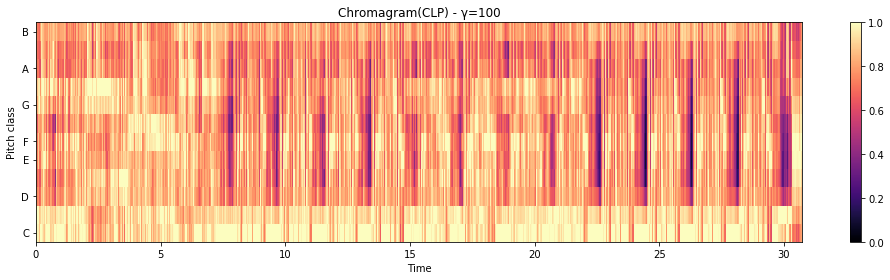

In [4]:
S = librosa.feature.melspectrogram(y=y, sr=sr)
get_Chromagram_from_spectragram(S, 100, sr=44100, to_plot=True, method='CLP')

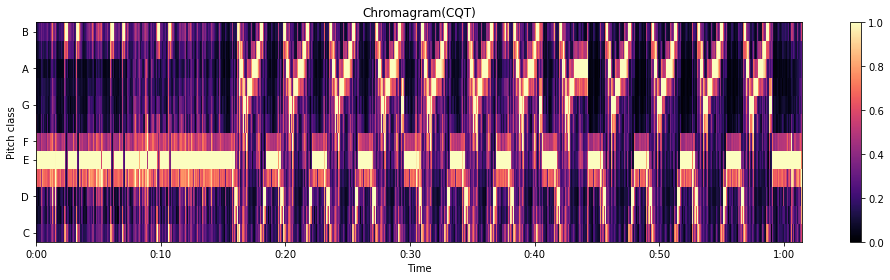

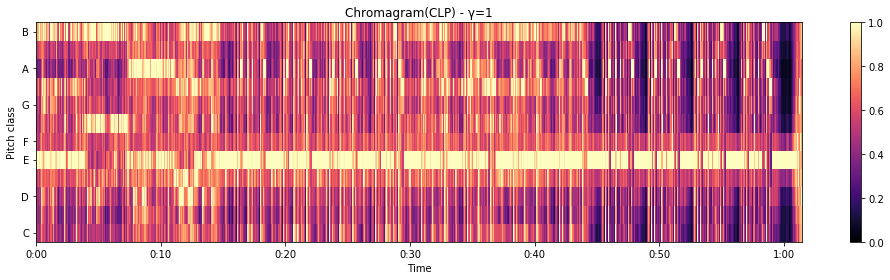

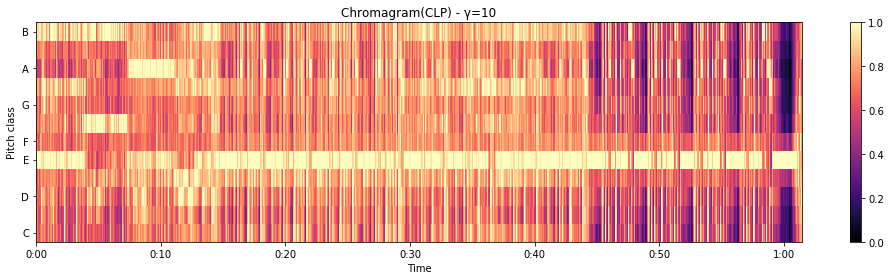

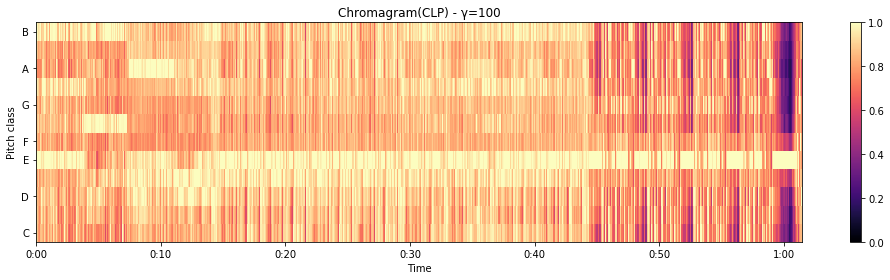

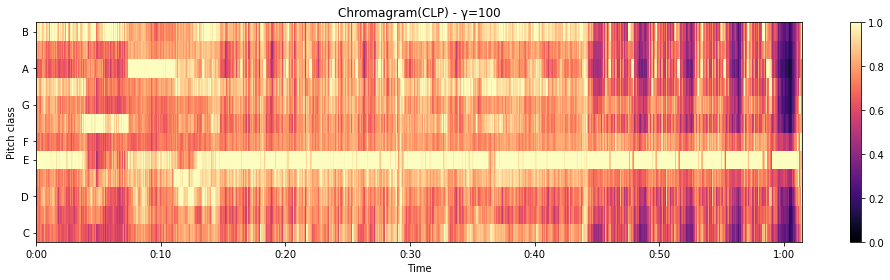

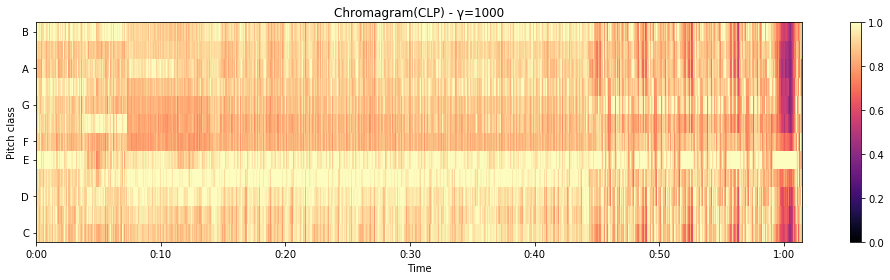

In [5]:
_ = get_Chromagram(y, sr, 0, method='cqt')
_ = get_Chromagram(y, sr, 1, method='clp')
_ = get_Chromagram(y, sr, 10, method='clp')
C = get_Chromagram(y, sr, 100, method='clp')
C = get_Chromagram(y, sr, 100, y_source='harmonic', method='clp')
_ = get_Chromagram(y, sr, 1000, method='clp')

## Key Matching

In [6]:
# Generate major key templates
Major_template = np.array([[1,0,1,0,1,1,0,1,0,1,0,1]])/np.sqrt(7.0) # C maj
# Generate monor key templates
Minor_template = np.array([[1,0,1,1,0,1,0,1,1,0,1,0]])/np.sqrt(7.0) # C min

key_template = Major_template
for i in range(11):
    key_template = np.append(key_template, np.roll(Major_template, i+1), axis=0)    
for i in range(12):
    key_template = np.append(key_template, np.roll(Minor_template, i), axis=0)
    
key_template.shape

(24, 12)

In [7]:
def get_key(chroma, key_template, method='sum', medfilter=False, blue_tone=None):
    if method == 'dot':
        if blue_tone:
            chroma[6]=np.zeros(chroma.shape[1])
        chroma = chroma/np.tile(np.sum(np.abs(chroma)**2, axis=0)**(1./2), \
                                (chroma.shape[0], 1)) # normalized chroma by the square sum of each time point
        dot_result = np.dot(key_template, chroma) # dot product with chroma and template

        tonic = dot_result.argmax(axis=0) # tonic in each time point
        
        if medfilter:
            tonic = scipy.signal.medfilt(tonic, kernel_size = 21) # median filter as post-processing
        
        key_count_dict = Counter(tonic)
        tonic = int(key_count_dict.most_common()[0][0])
        
        return tonic
    
    elif method == 'sum':
        summed_chroma = np.sum(chroma, axis=1) # sum up all the chroma
        if blue_tone: summed_chroma[6]=0
        tonic = summed_chroma.argmax()
        maj_cc = np.dot(key_template[tonic], summed_chroma)
        min_cc = np.dot(key_template[tonic+12], summed_chroma)
        
        if maj_cc > min_cc: # Major Key
            return tonic 
        else: # Minor Key
            return tonic+12
        
# note_converter = np.vectorize(lambda chord: (chord+3)%12 if chord/12 < 1 else ((chord+3)%12)+12)

def note_converter(tonic):
    return (tonic+3)%12 if tonic/12 < 1 else ((tonic+3)%12)+12

In [8]:
ex_key = get_key(C, key_template)
ex_key

4

In [9]:
ex_key = get_key(C, key_template, method='dot')
ex_key

11

## Hyper-parameters

In [10]:
dataset_dir = "../datasets/genres"
label_dir = "../datasets/gtzan_key/genres"

genres = ["pop", "blues", "metal", "hiphop", "rock"]
genres_ = ["country", "disco", "jazz", "reggae"] # all "classical", are -1
working_genres = [os.path.join(dataset_dir, dir_) for dir_ in genres]
working_genres

['../datasets/genres/pop',
 '../datasets/genres/blues',
 '../datasets/genres/metal',
 '../datasets/genres/hiphop',
 '../datasets/genres/rock']

In [11]:
def get_label(file_loc):
    with open(file_loc) as f:
        y = int(f.read().strip())
    if y == -1: 
        return None
    else:
        return y

def read_get_features(dataset_dir, 
                      label_dir, 
                      genres,
                      spectrum = 'stft',
                      y_source='source',
                      hop_length=None,
                      n_fft=2048):
    working_genres = [os.path.join(dataset_dir, dir_) for dir_ in genres]
    
    feature_dict = {genre: {'features':[],'labels':[],'filenames':[]} for genre in genres}
    
    for dir_path, _, fileNames in os.walk(dataset_dir): # go through every folders/files in datasets
        if dir_path not in working_genres: # only compute the target classes
            continue
        genre = dir_path.split('/')[-1] # to get current working genre
        print("Working on " + genre.upper())
        # Load musics
        for fileName in fileNames:
            label_filename = ".".join(fileName.split('.')[:-1]+['lerch.txt'])
            y_label = get_label(os.path.join(os.path.join(label_dir, genre),label_filename))

            if not y_label: # if label is ambiguous
                continue
            
            y, sr = librosa.load(os.path.join(dir_path,fileName))
            
            if y_source == 'harmonic':
                # We'll use the harmonic component to avoid pollution from transients
                # y_harmonic, y_percussive = librosa.effects.hpss(y)
                y, _ = librosa.effects.hpss(y)
            
            if spectrum == 'stft':
                spectrum_features = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)) # spectragram with STFT
            elif spectrum == 'mel':
                spectrum_features = librosa.feature.melspectrogram(y=y, sr=sr) # spectragram with constantQ

            feature_dict[genre]['features'].append(spectrum_features)
            feature_dict[genre]['labels'].append(y_label)
            feature_dict[genre]['filenames'].append(fileName)
            
    return feature_dict

### Keep spectral features in file, for the faster processing

In [12]:
# Read features from pickle
# genres_ = ["classical", "country", "disco", "jazz", "reggae"]
# with open("../datasets/spectrum_features_other.pkl","rb") as f:
#     feature_dict_ = pickle.load(f)
    
# print("Features Loads")

In [14]:
feature_dict = read_get_features(dataset_dir, label_dir, genres)

with open("../datasets/spectrum_features.pkl","wb") as f:
    pickle.dump(feature_dict,f)

print("Features Dumped")

Working on ROCK
Working on HIPHOP
Working on POP
Working on METAL
Working on BLUES
Features Dumped


In [15]:
# Read features from pickle
# with open("../datasets/spectrum_features.pkl","rb") as f:
#     feature_dict = pickle.load(f)
    
# print("Features Loads")

### Key Detection with CLP(chromagram with logarithmic compression)

\begin{equation}
log(1+\gamma |x|)
\end{equation}

<center>,where $\gamma = 100$<center>

### CLP with pre-compute spectragram

In [16]:
def key_detection_pipeline_pre(feature_dict, 
                               gammas=[100],
                               genres = genres,
                               weight_eval = False,
                               key_template = key_template,
                               y_source='source',
                               match_method='sum',
                               medfilter=False, 
                               plot_chroma=False, 
                               verbose = False,
                               blue_tone = False,
                               out_file = None
                              ):
       
    guesses = defaultdict(lambda:defaultdict(lambda:[])) # dictionary to save the precict result for each gamma
    labels  = defaultdict(lambda:defaultdict(lambda:[])) # dictionary to save the true label for each gamma
    
    if out_file:
        out = open(out_file,'w')
    for genre in feature_dict:
        if blue_tone and genre=="blues":
            is_blue = True
        else:
            is_blue = False
        for gamma in gammas:
            if out_file:
                out.write("\nGamma: " + str(gamma) + "\n")
            for i, music_spectragram in enumerate(feature_dict[genre]['features']):
                chroma = get_Chromagram_from_spectragram(music_spectragram, gamma, sr=22050, to_plot=plot_chroma)
                key = get_key(chroma, key_template, method=match_method, medfilter=medfilter, blue_tone=is_blue)
                key = note_converter(key) # fit to label, because label is from A, ours are from C
                
                guesses[gamma][genre].append(key)
                
                if verbose:
                    print("{:8s}({:14s})\tGUESS:{:3d}, LABEL:{:3d}".format(genre.upper(), feature_dict[genre]['filenames'][i], key, feature_dict[genre]['labels'][i]))
                if out_file:
                    out.write("{:8s}\t{:14s}\tGUESS:{:3d}, LABEL:{:3d}\n".format(genre.upper(), feature_dict[genre]['filenames'][i], key, feature_dict[genre]['labels'][i]))
            labels[gamma][genre] = feature_dict[genre]['labels']
    if out:
        out.close()
            
    # Evaluation
    for gamma in gammas:
        print("Gamma: " + str(gamma))
        evaluation(labels[gamma], guesses[gamma], genres, weighted=weight_eval)

perfect_fifth_dict = {3:10, 10:5, 5:0, 0:7, 7:2, 2:9, 9:4, 4:11, 11:6, 6:1, 1:8, 8:3, 
                      12:19,19:14, 14:21, 21:16, 16:23, 23:18, 18:13, 13:20, 20:15, 15:22, 22:17, 17:12}
relative_dict = {3:12, 12:3, 10:19, 19:10, 5:14, 14:5, 0:21, 21:0, 7:16, 16:7, 2:23, 23:2,  
                 9:18, 18:9, 4:13, 13:4, 11:20, 20:11, 6:15, 15:6, 1:22, 22:1, 8:17, 17:8}
    
def evaluation(y_true_dict, 
               y_predict_dict, 
               genres = genres, 
               weighted = False, 
               to_classification_report=False, 
               target_names = ["A","A#","B","C","C#","D","D#","E","F","F#","G","G#","a","a#","b","c","c#","d","d#","e","f","f#","g","g#"], 
               perfect_fifth_dict = perfect_fifth_dict, 
               relative_dict = relative_dict):
    # classification report
    if to_classification_report:
        for genre in genres:
            print(genre)
            print(classification_report(y_true_dict[genre], y_predict_dict[genre], target_names=target_names))
            print()
    class_acc = []
    if weighted:
        print("Weighted accuracy")
        for genre in genres:
            correct = 0.0
            for i, label in enumerate(y_true_dict[genre]):
                if y_predict_dict[genre][i] == label: # same
                    correct += 1
                if perfect_fifth_dict[y_predict_dict[genre][i]] == label: # perfect fifth error
                    correct += 0.5
                if relative_dict[y_predict_dict[genre][i]] == label: # Relative major/minor error
                    correct += 0.3
                if (y_predict_dict[genre][i]%12) == (label%12): # parallel major/minor
                    correct += 0.2
            class_acc.append(correct/len(y_predict_dict[genre]))
            print("{:8s}\t{:.2f}%".format(genre.upper(), correct/len(y_predict_dict[genre])*100))
    else:
        print("Average accuracy")
        for genre in genres:
            correct = 0.0
            for i, label in enumerate(y_true_dict[genre]):
                if label == y_predict_dict[genre][i]:
                    correct += 1
            try:
                class_acc.append(correct/len(y_predict_dict[genre]))
            except:class_acc.append(0.0)
            print("{:8s}\t{:.2f}%".format(genre.upper(), correct/len(y_predict_dict[genre])*100))
    print("{:8s}\t{:.2f}%".format("ALL AVG", sum(class_acc)/len(class_acc)*100))

## Q1

In [17]:
%%time
# process from pre-compute feature
key_detection_pipeline_pre(feature_dict,gammas = [100], out_file="Q1.txt")

"""
Gamma: 100
Average accuracy
POP     	9.78%
BLUES   	2.04%
METAL   	6.52%
HIPHOP  	6.33%
ROCK    	11.11%
ALL AVG 	7.16%
"""

Gamma: 100
Average accuracy
POP     	8.70%
BLUES   	2.04%
METAL   	5.43%
HIPHOP  	7.59%
ROCK    	10.00%
ALL AVG 	6.75%
CPU times: user 5min, sys: 19.3 s, total: 5min 19s
Wall time: 40.3 s


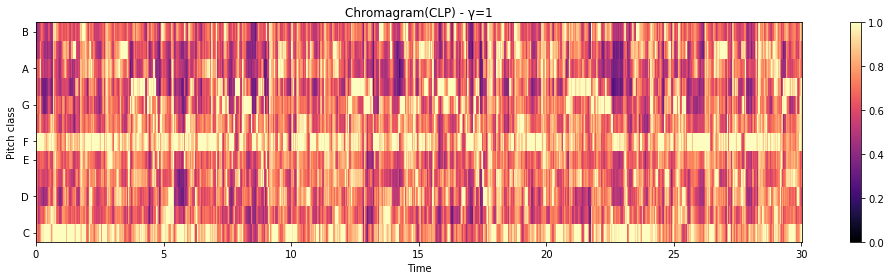

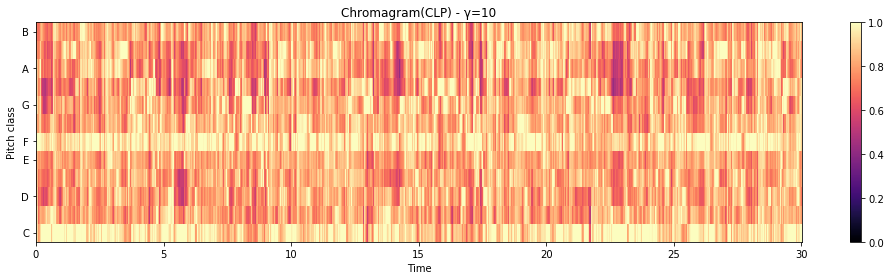

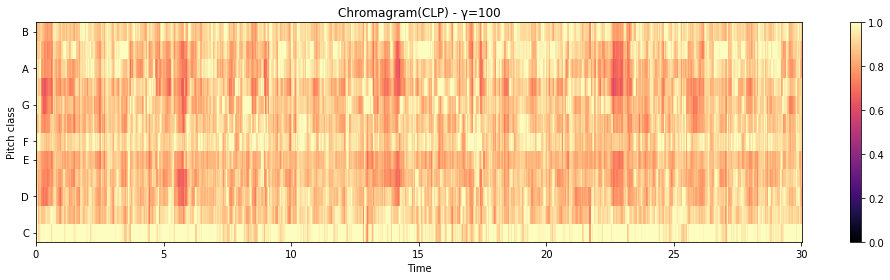

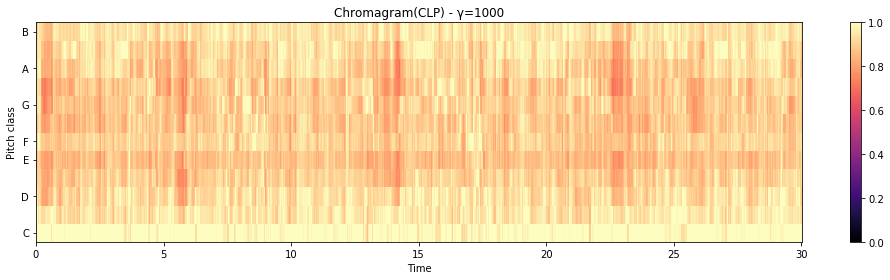

In [18]:
# check blue
_ = get_Chromagram_from_spectragram(feature_dict['blues']['features'][0], 1, sr=22050, method='clp')
_ = get_Chromagram_from_spectragram(feature_dict['blues']['features'][0], 10, sr=22050, method='clp')
_ = get_Chromagram_from_spectragram(feature_dict['blues']['features'][0], 100, sr=22050, method='clp')
_ = get_Chromagram_from_spectragram(feature_dict['blues']['features'][0], 1000, sr=22050, method='clp')

In [19]:
# %%time
# windows 4096
# process from pre-compute feature
# key_detection_pipeline_pre(feature_dict_, genres=genres,gammas = [100])

"""
Gamma: 100
Average accuracy
POP     	9.78%
BLUES   	3.06%
METAL   	6.52%
HIPHOP  	6.33%
ROCK    	10.00%
ALL AVG 	7.14%
"""

'\nGamma: 100\nAverage accuracy\nPOP     \t9.78%\nBLUES   \t3.06%\nMETAL   \t6.52%\nHIPHOP  \t6.33%\nROCK    \t10.00%\nALL AVG \t7.14%\n'

In [20]:
# %%time
# windows 8192
# process from pre-compute feature
# key_detection_pipeline_pre(feature_dict_8192, genres=genres,gammas = [100])
"""
Gamma: 100
Average accuracy
POP     	8.70%
BLUES   	3.06%
METAL   	6.52%
HIPHOP  	6.33%
ROCK    	10.00%
ALL AVG 	6.92%
"""

'\nGamma: 100\nAverage accuracy\nPOP     \t8.70%\nBLUES   \t3.06%\nMETAL   \t6.52%\nHIPHOP  \t6.33%\nROCK    \t10.00%\nALL AVG \t6.92%\n'

In [21]:
# %%time
# other 5 genres
# process from pre-compute feature
# key_detection_pipeline_pre(feature_dict_, genres=genres_,gammas = [100])

"""
Gamma: 100
Average accuracy
COUNTRY 	13.64%
DISCO   	20.21%
JAZZ    	8.97%
REGGAE  	20.88%
ALL AVG 	15.93%
"""

'\nGamma: 100\nAverage accuracy\nCOUNTRY \t13.64%\nDISCO   \t20.21%\nJAZZ    \t8.97%\nREGGAE  \t20.88%\nALL AVG \t15.93%\n'

## Q2
### Different $\Gamma = \{1,10,100,1000\}$ Parameters

In [22]:
%%time
key_detection_pipeline_pre(feature_dict, gammas = [1, 10,100,1000], out_file="Q2.txt")

"""
Gamma: 1
Average accuracy
POP     	27.17%
BLUES   	2.04%
METAL   	7.61%
HIPHOP  	8.86%
ROCK    	20.00%
ALL AVG 	13.14%
Gamma: 10
Average accuracy
POP     	23.91%
BLUES   	3.06%
METAL   	4.35%
HIPHOP  	7.59%
ROCK    	14.44%
ALL AVG 	10.67%
Gamma: 100
Average accuracy
POP     	9.78%
BLUES   	2.04%
METAL   	6.52%
HIPHOP  	6.33%
ROCK    	11.11%
ALL AVG 	7.16%
Gamma: 1000
Average accuracy
POP     	8.70%
BLUES   	2.04%
METAL   	6.52%
HIPHOP  	5.06%
ROCK    	8.89%
ALL AVG 	6.24%
"""

Gamma: 1
Average accuracy
POP     	30.43%
BLUES   	2.04%
METAL   	14.13%
HIPHOP  	13.92%
ROCK    	24.44%
ALL AVG 	16.99%
Gamma: 10
Average accuracy
POP     	18.48%
BLUES   	2.04%
METAL   	7.61%
HIPHOP  	10.13%
ROCK    	15.56%
ALL AVG 	10.76%
Gamma: 100
Average accuracy
POP     	8.70%
BLUES   	2.04%
METAL   	5.43%
HIPHOP  	7.59%
ROCK    	10.00%
ALL AVG 	6.75%
Gamma: 1000
Average accuracy
POP     	4.35%
BLUES   	1.02%
METAL   	5.43%
HIPHOP  	7.59%
ROCK    	10.00%
ALL AVG 	5.68%
CPU times: user 20min 4s, sys: 1min 17s, total: 21min 22s
Wall time: 2min 41s


In [23]:
# %%time
# other 5 genres
# key_detection_pipeline_pre(feature_dict_,  genres=genres_, gammas = [1,10,100,1000])

"""
Gamma: 1
Average accuracy
COUNTRY 	18.18%
DISCO   	17.02%
JAZZ    	14.10%
REGGAE  	29.67%
ALL AVG 	19.74%

Gamma: 10
Average accuracy
COUNTRY 	17.05%
DISCO   	21.28%
JAZZ    	15.38%
REGGAE  	30.77%
ALL AVG 	21.12%

Gamma: 100
Average accuracy
COUNTRY 	13.64%
DISCO   	20.21%
JAZZ    	8.97%
REGGAE  	20.88%
ALL AVG 	15.93%

Gamma: 1000
Average accuracy
COUNTRY 	11.36%
DISCO   	15.96%
JAZZ    	7.69%
REGGAE  	15.38%
ALL AVG 	12.60%
"""

'\nGamma: 1\nAverage accuracy\nCOUNTRY \t18.18%\nDISCO   \t17.02%\nJAZZ    \t14.10%\nREGGAE  \t29.67%\nALL AVG \t19.74%\n\nGamma: 10\nAverage accuracy\nCOUNTRY \t17.05%\nDISCO   \t21.28%\nJAZZ    \t15.38%\nREGGAE  \t30.77%\nALL AVG \t21.12%\n\nGamma: 100\nAverage accuracy\nCOUNTRY \t13.64%\nDISCO   \t20.21%\nJAZZ    \t8.97%\nREGGAE  \t20.88%\nALL AVG \t15.93%\n\nGamma: 1000\nAverage accuracy\nCOUNTRY \t11.36%\nDISCO   \t15.96%\nJAZZ    \t7.69%\nREGGAE  \t15.38%\nALL AVG \t12.60%\n'

## Q3
### Weighted Accuracy

0.5 Perfect fifth

0.3 Relative major/minor

0.2 Parallel major/minor

In [24]:
%%time
key_detection_pipeline_pre(feature_dict, gammas = [1,10,100,1000], weight_eval = True, out_file="Q3.txt")
"""
Gamma: 1
Weighted accuracy
POP     	40.00%
BLUES   	8.67%
METAL   	21.41%
HIPHOP  	20.00%
ROCK    	32.89%
ALL AVG 	24.60%
Gamma: 10
Weighted accuracy
POP     	29.46%
BLUES   	8.27%
METAL   	14.78%
HIPHOP  	16.08%
ROCK    	22.78%
ALL AVG 	18.27%
Gamma: 100
Weighted accuracy
POP     	18.80%
BLUES   	8.78%
METAL   	13.26%
HIPHOP  	11.52%
ROCK    	16.44%
ALL AVG 	13.76%
Gamma: 1000
Weighted accuracy
POP     	11.09%
BLUES   	6.12%
METAL   	11.74%
HIPHOP  	13.42%
ROCK    	18.67%
ALL AVG 	12.21%
"""

Gamma: 1
Weighted accuracy
POP     	40.00%
BLUES   	8.67%
METAL   	21.41%
HIPHOP  	20.00%
ROCK    	32.89%
ALL AVG 	24.60%
Gamma: 10
Weighted accuracy
POP     	29.46%
BLUES   	8.27%
METAL   	14.78%
HIPHOP  	16.08%
ROCK    	22.78%
ALL AVG 	18.27%
Gamma: 100
Weighted accuracy
POP     	18.80%
BLUES   	8.78%
METAL   	13.26%
HIPHOP  	11.52%
ROCK    	16.44%
ALL AVG 	13.76%
Gamma: 1000
Weighted accuracy
POP     	11.09%
BLUES   	6.12%
METAL   	11.74%
HIPHOP  	13.42%
ROCK    	18.67%
ALL AVG 	12.21%
CPU times: user 19min 38s, sys: 1min 15s, total: 20min 53s
Wall time: 2min 37s


## Q4: Krumhansl-Schmuckler's algorithm

In [25]:
# Generate major key templates
# C maj
KS_major_template = np.array([[6.35,2.23,3.48,2.33,4.38,4.09,2.52,5.19,2.39,3.66,2.29,2.88]])
KS_major_template = KS_major_template/np.sqrt(np.dot(KS_major_template, KS_major_template.T))
# Generate monor key templates
# C min
KS_minor_template = np.array([[6.33,2.68,3.52,5.38,2.60,3.53,2.54,4.75,3.98,2.69,3.34,3.17]]) 
KS_minor_template = KS_minor_template/np.sqrt(np.dot(KS_minor_template, KS_minor_template.T))

KS_key_template = KS_major_template
for i in range(11):
    KS_key_template = np.append(KS_key_template, np.roll(KS_major_template, i+1), axis=0)    
for i in range(12):
    KS_key_template = np.append(KS_key_template, np.roll(KS_minor_template, i), axis=0)
    
KS_key_template.shape

(24, 12)

In [26]:
%%time
key_detection_pipeline_pre(feature_dict, 
                           gammas = [1,10,100,1000],
                           key_template = KS_key_template,
                           out_file="Q4_different_gamma_sum_method.txt")
"""
Sum Method

Gamma: 1
Average accuracy
POP     	16.30%
BLUES   	30.61%
METAL   	22.83%
HIPHOP  	17.72%
ROCK    	17.78%
ALL AVG 	21.05%
Gamma: 10
Average accuracy
POP     	13.04%
BLUES   	23.47%
METAL   	13.04%
HIPHOP  	17.72%
ROCK    	13.33%
ALL AVG 	16.12%
Gamma: 100
Average accuracy
POP     	7.61%
BLUES   	24.49%
METAL   	9.78%
HIPHOP  	10.13%
ROCK    	7.78%
ALL AVG 	11.96%
Gamma: 1000
Average accuracy
POP     	5.43%
BLUES   	19.39%
METAL   	8.70%
HIPHOP  	8.86%
ROCK    	6.67%
ALL AVG 	9.81%
"""

Gamma: 1
Average accuracy
POP     	16.30%
BLUES   	30.61%
METAL   	22.83%
HIPHOP  	17.72%
ROCK    	17.78%
ALL AVG 	21.05%
Gamma: 10
Average accuracy
POP     	13.04%
BLUES   	23.47%
METAL   	13.04%
HIPHOP  	17.72%
ROCK    	13.33%
ALL AVG 	16.12%
Gamma: 100
Average accuracy
POP     	7.61%
BLUES   	24.49%
METAL   	9.78%
HIPHOP  	10.13%
ROCK    	7.78%
ALL AVG 	11.96%
Gamma: 1000
Average accuracy
POP     	5.43%
BLUES   	19.39%
METAL   	8.70%
HIPHOP  	8.86%
ROCK    	6.67%
ALL AVG 	9.81%
CPU times: user 19min 56s, sys: 1min 16s, total: 21min 12s
Wall time: 2min 39s


In [27]:
%%time
key_detection_pipeline_pre(feature_dict, 
                           gammas = [1,10,100,1000],
                           key_template = KS_key_template,
                           match_method='dot',
                           out_file="Q4_different_gamma_dot_method.txt")
"""
Dot Method

Gamma: 1
Average accuracy
POP     	23.91%
BLUES   	15.31%
METAL   	23.91%
HIPHOP  	16.46%
ROCK    	17.78%
ALL AVG 	19.47%
Gamma: 10
Average accuracy
POP     	19.57%
BLUES   	10.20%
METAL   	29.35%
HIPHOP  	15.19%
ROCK    	20.00%
ALL AVG 	18.86%
Gamma: 100
Average accuracy
POP     	13.04%
BLUES   	14.29%
METAL   	15.22%
HIPHOP  	7.59%
ROCK    	16.67%
ALL AVG 	13.36%
Gamma: 1000
Average accuracy
POP     	7.61%
BLUES   	18.37%
METAL   	7.61%
HIPHOP  	8.86%
ROCK    	8.89%
ALL AVG 	10.27%
"""

Gamma: 1
Average accuracy
POP     	23.91%
BLUES   	15.31%
METAL   	23.91%
HIPHOP  	16.46%
ROCK    	17.78%
ALL AVG 	19.47%
Gamma: 10
Average accuracy
POP     	19.57%
BLUES   	10.20%
METAL   	29.35%
HIPHOP  	15.19%
ROCK    	20.00%
ALL AVG 	18.86%
Gamma: 100
Average accuracy
POP     	13.04%
BLUES   	14.29%
METAL   	15.22%
HIPHOP  	7.59%
ROCK    	16.67%
ALL AVG 	13.36%
Gamma: 1000
Average accuracy
POP     	7.61%
BLUES   	18.37%
METAL   	7.61%
HIPHOP  	8.86%
ROCK    	8.89%
ALL AVG 	10.27%
CPU times: user 20min 6s, sys: 1min 16s, total: 21min 23s
Wall time: 2min 41s


In [28]:
%%time
key_detection_pipeline_pre(feature_dict,
                           gammas = [1,10,100,1000], 
                           key_template = KS_key_template,
                           weight_eval = True,
                           out_file="Q4_different_gamma_sum_weight.txt")
"""
Sum Method with weight evaluation

Gamma: 1
Weighted accuracy
POP     	25.33%
BLUES   	38.47%
METAL   	30.87%
HIPHOP  	27.47%
ROCK    	26.78%
ALL AVG 	29.78%
Gamma: 10
Weighted accuracy
POP     	20.76%
BLUES   	31.12%
METAL   	21.30%
HIPHOP  	26.08%
ROCK    	21.11%
ALL AVG 	24.07%
Gamma: 100
Weighted accuracy
POP     	13.48%
BLUES   	32.65%
METAL   	16.30%
HIPHOP  	17.72%
ROCK    	13.44%
ALL AVG 	18.72%
Gamma: 1000
Weighted accuracy
POP     	10.87%
BLUES   	28.06%
METAL   	12.83%
HIPHOP  	17.85%
ROCK    	13.22%
ALL AVG 	16.57%
"""

Gamma: 1
Weighted accuracy
POP     	25.33%
BLUES   	38.47%
METAL   	30.87%
HIPHOP  	27.47%
ROCK    	26.78%
ALL AVG 	29.78%
Gamma: 10
Weighted accuracy
POP     	20.76%
BLUES   	31.12%
METAL   	21.30%
HIPHOP  	26.08%
ROCK    	21.11%
ALL AVG 	24.07%
Gamma: 100
Weighted accuracy
POP     	13.48%
BLUES   	32.65%
METAL   	16.30%
HIPHOP  	17.72%
ROCK    	13.44%
ALL AVG 	18.72%
Gamma: 1000
Weighted accuracy
POP     	10.87%
BLUES   	28.06%
METAL   	12.83%
HIPHOP  	17.85%
ROCK    	13.22%
ALL AVG 	16.57%
CPU times: user 19min 58s, sys: 1min 16s, total: 21min 15s
Wall time: 2min 40s


In [29]:
%%time
key_detection_pipeline_pre(feature_dict, 
                           gammas = [1,10,100,1000],
                           key_template = KS_key_template,
                           match_method='dot',
                           weight_eval = True,
                           out_file="Q4_different_gamma_dot_weight.txt")

"""
Dot Method with weight evaluation

Gamma: 1
Weighted accuracy
POP     	37.07%
BLUES   	20.82%
METAL   	33.80%
HIPHOP  	22.66%
ROCK    	26.11%
ALL AVG 	28.09%
Gamma: 10
Weighted accuracy
POP     	27.72%
BLUES   	14.80%
METAL   	43.80%
HIPHOP  	22.03%
ROCK    	30.67%
ALL AVG 	27.80%
Gamma: 100
Weighted accuracy
POP     	19.02%
BLUES   	21.02%
METAL   	25.87%
HIPHOP  	10.38%
ROCK    	24.67%
ALL AVG 	20.19%
Gamma: 1000
Weighted accuracy
POP     	11.85%
BLUES   	25.31%
METAL   	16.09%
HIPHOP  	11.27%
ROCK    	16.11%
ALL AVG 	16.12%
"""

Gamma: 1
Weighted accuracy
POP     	37.07%
BLUES   	20.82%
METAL   	33.80%
HIPHOP  	22.66%
ROCK    	26.11%
ALL AVG 	28.09%
Gamma: 10
Weighted accuracy
POP     	27.72%
BLUES   	14.80%
METAL   	43.80%
HIPHOP  	22.03%
ROCK    	30.67%
ALL AVG 	27.80%
Gamma: 100
Weighted accuracy
POP     	19.02%
BLUES   	21.02%
METAL   	25.87%
HIPHOP  	10.38%
ROCK    	24.67%
ALL AVG 	20.19%
Gamma: 1000
Weighted accuracy
POP     	11.85%
BLUES   	25.31%
METAL   	16.09%
HIPHOP  	11.27%
ROCK    	16.11%
ALL AVG 	16.12%
CPU times: user 20min 59s, sys: 1min 17s, total: 22min 17s
Wall time: 2min 47s


## Q5
### Self Improve

### Source filtering and scale change

In [30]:
# feature_dict_hamonic = read_get_features(dataset_dir, label_dir, genres, y_source='hamonic')

# key_detection_pipeline_pre(feature_dict_hamonic, 
#                            gammas = [1,10,100,1000],
#                            key_template = KS_key_template,
#                            match_method='dot',
#                            weight_eval = True)

"""
Decompose D into harmonic and percussive components

Using only harmonic part.

This assumes that all energy belongs to either a harmonic or percussive source, 
but does not handle “noise” well. Noise energy ends up getting spread between D_harmonic and D_percussive.

Gamma: 1
Weighted accuracy
POP     	35.65%
BLUES   	25.31%
METAL   	33.37%
HIPHOP  	23.80%
ROCK    	26.67%
ALL AVG 	28.96%
Gamma: 10
Weighted accuracy
POP     	34.89%
BLUES   	11.63%
METAL   	38.04%
HIPHOP  	21.90%
ROCK    	28.89%
ALL AVG 	27.07%
Gamma: 100
Weighted accuracy
POP     	27.83%
BLUES   	23.67%
METAL   	22.17%
HIPHOP  	17.72%
ROCK    	23.33%
ALL AVG 	22.95%
Gamma: 1000
Weighted accuracy
POP     	24.13%
BLUES   	25.31%
METAL   	13.48%
HIPHOP  	16.33%
ROCK    	17.56%
ALL AVG 	19.36%
"""

'\nDecompose D into harmonic and percussive components\n\nUsing only harmonic part.\n\nThis assumes that all energy belongs to either a harmonic or percussive source, \nbut does not handle “noise” well. Noise energy ends up getting spread between D_harmonic and D_percussive.\n\nGamma: 1\nWeighted accuracy\nPOP     \t35.65%\nBLUES   \t25.31%\nMETAL   \t33.37%\nHIPHOP  \t23.80%\nROCK    \t26.67%\nALL AVG \t28.96%\nGamma: 10\nWeighted accuracy\nPOP     \t34.89%\nBLUES   \t11.63%\nMETAL   \t38.04%\nHIPHOP  \t21.90%\nROCK    \t28.89%\nALL AVG \t27.07%\nGamma: 100\nWeighted accuracy\nPOP     \t27.83%\nBLUES   \t23.67%\nMETAL   \t22.17%\nHIPHOP  \t17.72%\nROCK    \t23.33%\nALL AVG \t22.95%\nGamma: 1000\nWeighted accuracy\nPOP     \t24.13%\nBLUES   \t25.31%\nMETAL   \t13.48%\nHIPHOP  \t16.33%\nROCK    \t17.56%\nALL AVG \t19.36%\n'

In [31]:
# feature_dict_hamonic = read_get_features(dataset_dir, label_dir, genres, y_source='hamonic', spectrum = 'mel')

# key_detection_pipeline_pre(feature_dict_hamonic, 
#                            gammas = [1,10,100,1000],
#                            key_template = KS_key_template,
#                            match_method='dot',
#                            weight_eval = True)

"""
Previous we calculate Spectrum from stft

Now we using melspectrogram as output

FOllowing input to CLP to calculate the result

Gamma: 1
Weighted accuracy
POP     	24.89%
BLUES   	22.65%
METAL   	28.15%
HIPHOP  	24.18%
ROCK    	26.78%
ALL AVG 	25.33%
Gamma: 10
Weighted accuracy
POP     	26.96%
BLUES   	22.55%
METAL   	31.09%
HIPHOP  	25.95%
ROCK    	28.44%
ALL AVG 	27.00%
Gamma: 100
Weighted accuracy
POP     	21.85%
BLUES   	26.73%
METAL   	27.07%
HIPHOP  	24.30%
ROCK    	24.22%
ALL AVG 	24.83%
Gamma: 1000
Weighted accuracy
POP     	18.70%
BLUES   	26.53%
METAL   	30.65%
HIPHOP  	23.29%
ROCK    	25.11%
ALL AVG 	24.86%
"""

'\nPrevious we calculate Spectrum from stft\n\nNow we using melspectrogram as output\n\nFOllowing input to CLP to calculate the result\n\nGamma: 1\nWeighted accuracy\nPOP     \t24.89%\nBLUES   \t22.65%\nMETAL   \t28.15%\nHIPHOP  \t24.18%\nROCK    \t26.78%\nALL AVG \t25.33%\nGamma: 10\nWeighted accuracy\nPOP     \t26.96%\nBLUES   \t22.55%\nMETAL   \t31.09%\nHIPHOP  \t25.95%\nROCK    \t28.44%\nALL AVG \t27.00%\nGamma: 100\nWeighted accuracy\nPOP     \t21.85%\nBLUES   \t26.73%\nMETAL   \t27.07%\nHIPHOP  \t24.30%\nROCK    \t24.22%\nALL AVG \t24.83%\nGamma: 1000\nWeighted accuracy\nPOP     \t18.70%\nBLUES   \t26.53%\nMETAL   \t30.65%\nHIPHOP  \t23.29%\nROCK    \t25.11%\nALL AVG \t24.86%\n'

### Temperley template

In [32]:
# Generate major key templates
# C maj
KP_major_template = np.array([[5,2,3.5,2,4.5,4.0,2.0,4.5,2.0,3.5,1.5,4.0]])
KP_major_template = KP_major_template/np.sqrt(np.dot(KP_major_template, KP_major_template.T))
# Generate monor key templates
# C min
KP_minor_template = np.array([[5.0,2.0,3.5,4.5,2.0,4.0,2.0,4.5,3.5,2.0,1.5,4.0]]) 
KP_minor_template = KP_minor_template/np.sqrt(np.dot(KP_minor_template, KP_minor_template.T))

KP_key_template = KP_major_template
for i in range(11):
    KP_key_template = np.append(KP_key_template, np.roll(KP_major_template, i+1), axis=0)    
for i in range(12):
    KP_key_template = np.append(KP_key_template, np.roll(KP_minor_template, i), axis=0)
    
KP_key_template.shape

(24, 12)

In [33]:
%%time
key_detection_pipeline_pre(feature_dict, 
                           gammas = [1,10,100,1000],
                           key_template = KP_key_template,
                           match_method='dot',
                           weight_eval = True,
                           out_file="Q5_Temperley_template.txt")

"""
Gamma: 1
Weighted accuracy
POP     	39.89%
BLUES   	16.33%
METAL   	26.09%
HIPHOP  	17.22%
ROCK    	42.78%
ALL AVG 	28.46%
Gamma: 10
Weighted accuracy
POP     	27.07%
BLUES   	13.57%
METAL   	25.65%
HIPHOP  	12.41%
ROCK    	44.44%
ALL AVG 	24.63%
Gamma: 100
Weighted accuracy
POP     	18.26%
BLUES   	10.71%
METAL   	24.13%
HIPHOP  	18.73%
ROCK    	34.11%
ALL AVG 	21.19%
Gamma: 1000
Weighted accuracy
POP     	14.02%
BLUES   	14.49%
METAL   	13.70%
HIPHOP  	19.75%
ROCK    	35.11%
ALL AVG 	19.41%
"""

Gamma: 1
Weighted accuracy
POP     	39.89%
BLUES   	16.33%
METAL   	26.09%
HIPHOP  	17.22%
ROCK    	42.78%
ALL AVG 	28.46%
Gamma: 10
Weighted accuracy
POP     	27.07%
BLUES   	13.57%
METAL   	25.65%
HIPHOP  	12.41%
ROCK    	44.44%
ALL AVG 	24.63%
Gamma: 100
Weighted accuracy
POP     	18.26%
BLUES   	10.71%
METAL   	24.13%
HIPHOP  	18.73%
ROCK    	34.11%
ALL AVG 	21.19%
Gamma: 1000
Weighted accuracy
POP     	14.02%
BLUES   	14.49%
METAL   	13.70%
HIPHOP  	19.75%
ROCK    	35.11%
ALL AVG 	19.41%
CPU times: user 20min 52s, sys: 1min 17s, total: 22min 9s
Wall time: 2min 47s
